In [1]:
import pandas as pd
import numpy as np

# Load ASASSN data
asassn_file = "data/light_curve_ASASSN.csv"
asassn_data = pd.read_csv(asassn_file)

# Filter ASASSN data
asassn_data = asassn_data[asassn_data['mag_err'] != 99.990]
asassn_data['mag'] = asassn_data['mag'].astype(str).str.replace('>', '').astype(float)
asassn_data['MJD'] = asassn_data['HJD'] - 2400000.5

df_g = asassn_data[asassn_data['Filter'] == 'g']
df_V = asassn_data[asassn_data['Filter'] == 'V']

# Calculate means < MJD 59900
mean_g_mag = df_g[df_g['MJD'] < 59900]['mag'].mean()
mean_g_err = df_g[df_g['MJD'] < 59900]['mag_err'].mean()
mean_g_flux = df_g[df_g['MJD'] < 59900]['flux(mJy)'].mean()


mean_V_mag = df_V[df_V['MJD'] < 59900]['mag'].mean()
mean_V_err = df_V[df_V['MJD'] < 59900]['mag_err'].mean()
mean_V_flux = df_V[df_V['MJD'] < 59900]['flux(mJy)'].mean()

# Bin ASASSN g
bin_size_points = 10
df_g = df_g.sort_values(by='MJD')
num_bins = len(df_g) // bin_size_points + (1 if len(df_g) % bin_size_points != 0 else 0)
df_g['point_bin'] = np.repeat(range(num_bins), bin_size_points)[:len(df_g)]
binned_g = (
    df_g.groupby('point_bin')
    .agg(
        mjd_bin_center=('MJD', lambda x: round(x.mean(), 2)),
        mag_bin=('mag', lambda x: round(x.mean(), 3)),
        magerr_bin=('mag_err', 'mean')
    )
    .reset_index()
)

# Identify brightest bin
brightest_bin = binned_g.loc[binned_g['mag_bin'].idxmin()]
lowest_bin_index = brightest_bin['point_bin']
lowest_bin_mjd = brightest_bin['mjd_bin_center']
lowest_bin_mag = brightest_bin['mag_bin']

# Identify the last bin
last_bin = binned_g.iloc[-1]
last_bin_mjd = last_bin['mjd_bin_center']
last_bin_mag = last_bin['mag_bin']

print(f"brightest bin: Index = {lowest_bin_index}, Mean MJD = {lowest_bin_mjd:.2f}, "
      f"Mean Magnitude = {lowest_bin_mag:.3f}")
print(f"Last bin: Mean MJD = {last_bin_mjd:.2f}, Mean Magnitude = {last_bin_mag:.3f}")


brightest bin: Index = 146.0, Mean MJD = 60004.42, Mean Magnitude = 14.267
Last bin: Mean MJD = 60645.15, Mean Magnitude = 15.468


In [2]:
# Load & filter WISE data
wise_file_path = "data/J031413.43-223544.03_WISE_data.csv"
wise_data = pd.read_csv(wise_file_path)
print(len(wise_data))
wise_data = wise_data[
    (wise_data['sso_flg'] == 0) & 
    (wise_data['qual_frame'] != 0) & 
    (wise_data['qi_fact'] > 0) & 
    (wise_data['moon_masked'] == 0)
]

wise_data = wise_data.sort_values(by='mjd').reset_index(drop=True)

# Calculate baseline
mean_w1_mag = wise_data[wise_data['mjd'] < 59900]['w1mpro'].mean()
mean_w1_err = wise_data[wise_data['mjd'] < 59900]['w1sigmpro'].mean()

mean_w2_mag = wise_data[wise_data['mjd'] < 59900]['w2mpro'].mean()
mean_w2_err = wise_data[wise_data['mjd'] < 59900]['w2sigmpro'].mean()

mean_w1_flux = wise_data[wise_data['mjd'] < 59900]['w1flux'].mean()
mean_w2_flux = wise_data[wise_data['mjd'] < 59900]['w2flux'].mean()


epoch_duration = 30 
current_epoch = 1
current_epoch_start = wise_data.iloc[0]['mjd'] 

# Create epoch column
epoch_column = []
for mjd in wise_data['mjd']:
    if mjd > current_epoch_start + epoch_duration:
        current_epoch += 1  
        current_epoch_start = mjd 
    epoch_column.append(current_epoch)

wise_data['epoch'] = epoch_column

# Calculate mean and error for each epoch...
epoch_means = wise_data.groupby('epoch').agg(
    mean_w1=('w1mpro', 'mean'),
    mean_w2=('w2mpro', 'mean'),
    mean_w1_err=('w1sigmpro', 'mean'),
    mean_w2_err=('w2sigmpro', 'mean'),
    mean_mjd=('mjd', 'mean')
).reset_index()

epoch_22 = epoch_means[epoch_means['epoch'] == 22]
epoch_25 = epoch_means[epoch_means['epoch'] == 25]

mean_w1_22, err_w1_22 = epoch_22['mean_w1'].values[0], epoch_22['mean_w1_err'].values[0]
mean_w1_25, err_w1_25 = epoch_25['mean_w1'].values[0], epoch_25['mean_w1_err'].values[0]
mean_w2_22, err_w2_22 = epoch_22['mean_w2'].values[0], epoch_22['mean_w2_err'].values[0]
mean_w2_25, err_w2_25 = epoch_25['mean_w2'].values[0], epoch_25['mean_w2_err'].values[0]

print(f"Epoch 22:\n"
      f"  Mean MJD: {epoch_22['mean_mjd'].values[0]:.2f}\n"
      f"  W1: {epoch_22['mean_w1'].values[0]:.3f} ± {epoch_22['mean_w1_err'].values[0]:.3f}\n"
      f"  W2: {epoch_22['mean_w2'].values[0]:.3f} ± {epoch_22['mean_w2_err'].values[0]:.3f}")

print(f"Epoch 25:\n"
      f"  Mean MJD: {epoch_25['mean_mjd'].values[0]:.2f}\n"
      f"  W1: {epoch_25['mean_w1'].values[0]:.3f} ± {epoch_25['mean_w1_err'].values[0]:.3f}\n"
      f"  W2: {epoch_25['mean_w2'].values[0]:.3f} ± {epoch_25['mean_w2_err'].values[0]:.3f}")

print(f"Before MJD 59600:\n"
      f"  Mean W1: {mean_w1_mag:.3f} ± {mean_w1_err:.3f}\n"
      f"  Mean W2: {mean_w2_mag:.3f} ± {mean_w2_err:.3f}")


360
Epoch 22:
  Mean MJD: 59952.06
  W1: 12.532 ± 0.027
  W2: 12.066 ± 0.039
Epoch 25:
  Mean MJD: 60523.09
  W1: 12.651 ± 0.033
  W2: 12.357 ± 0.064
Before MJD 59600:
  Mean W1: 14.245 ± 0.065
  Mean W2: 13.611 ± 0.118


C:\Users\arttu\AppData\Local\Temp\ipykernel_2108\2198326677.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V['normalized_flux'] = df_V['flux(mJy)'] / mean_V_flux


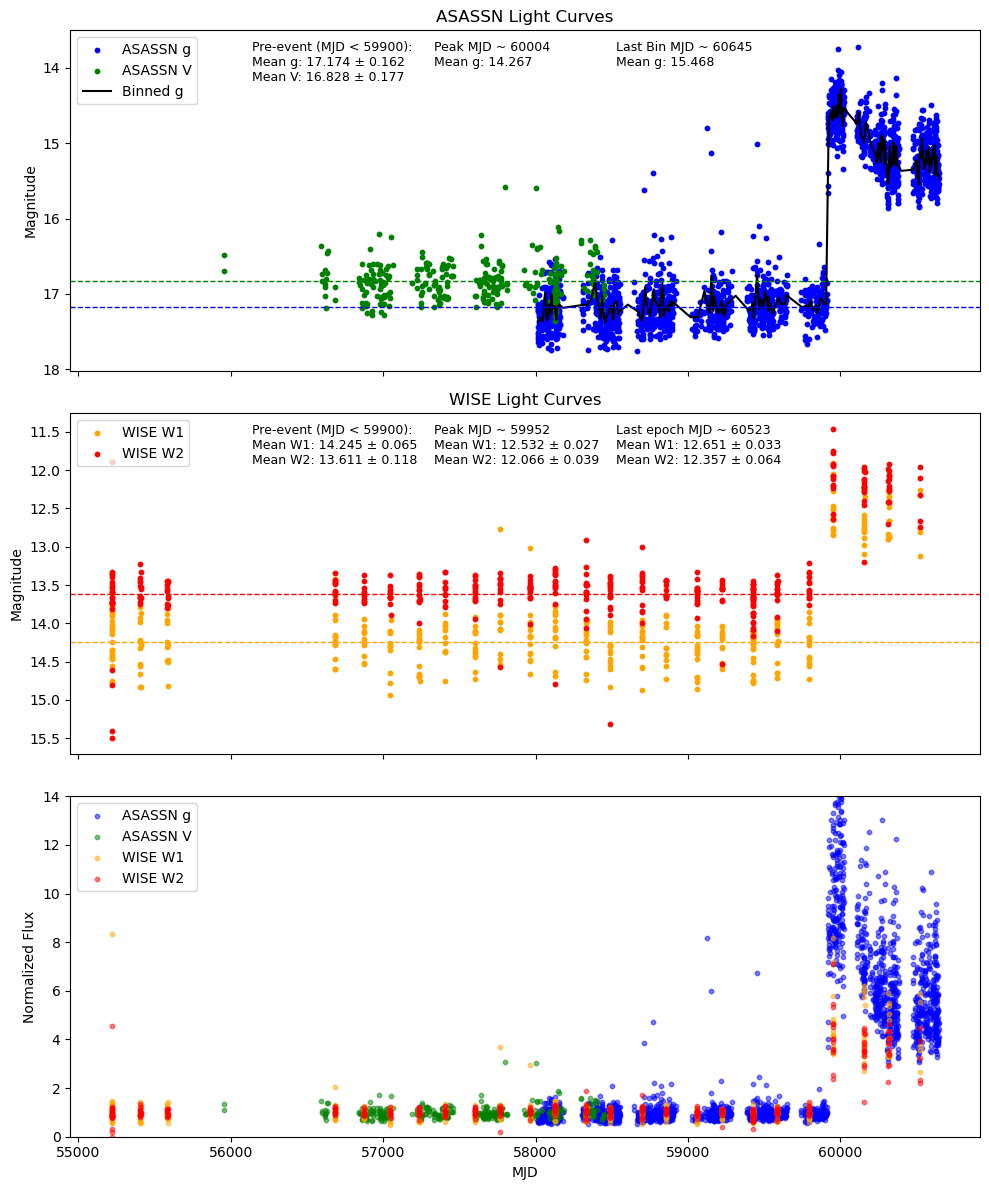

In [3]:
import matplotlib.pyplot as plt

#ASASSN TEXT:
# Create text for the brightest and last bins

text_peak = (
    f"Peak MJD ~ {lowest_bin_mjd:.0f}\n"
    f"Mean g: {lowest_bin_mag:.3f}"
)

text_last_bin = (
    f"Last Bin MJD ~ {last_bin_mjd:.0f}\n"
    f"Mean g: {last_bin_mag:.3f}"
)

text_mean_asassn = (
    f"Pre-event (MJD < 59900):\n"
    f"Mean g: {mean_g_mag:.3f} ± {mean_g_err:.3f}\n"
    f"Mean V: {mean_V_mag:.3f} ± {mean_V_err:.3f}"
)


#WISE TEXT:
text_22 = (
    f"Peak MJD ~ {epoch_22['mean_mjd'].values[0]:.0f}\n"
    f"Mean W1: {mean_w1_22:.3f} ± {err_w1_22:.3f}\n"
    f"Mean W2: {mean_w2_22:.3f} ± {err_w2_22:.3f}"
)

text_last = (
    f"Last epoch MJD ~ {epoch_25['mean_mjd'].values[0]:.0f}\n"
    f"Mean W1: {mean_w1_25:.3f} ± {err_w1_25:.3f}\n"
    f"Mean W2: {mean_w2_25:.3f} ± {err_w2_25:.3f}"
)


text_mean_wise = (
    f"Pre-event (MJD < 59900):\n"
    f"Mean W1: {mean_w1_mag:.3f} ± {mean_w1_err:.3f}\n"
    f"Mean W2: {mean_w2_mag:.3f} ± {mean_w2_err:.3f}"
)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Top Plot: ASASSN g and V
axs[0].scatter(df_g['MJD'], df_g['mag'], color='blue', label='ASASSN g', s=10)
axs[0].scatter(df_V['MJD'], df_V['mag'], color='green', label='ASASSN V', s=10)
axs[0].plot(binned_g['mjd_bin_center'], binned_g['mag_bin'], color='k', label='Binned g', lw=1.5)

axs[0].invert_yaxis()
axs[0].set_ylabel('Magnitude')
axs[0].legend(loc="upper left")
axs[0].axhline(mean_g_mag, color='blue', linestyle='--', linewidth=1, label=f'Mean g = {mean_g_mag:.3f}')
axs[0].axhline(mean_V_mag, color='green', linestyle='--', linewidth=1, label=f'Mean V = {mean_V_mag:.3f}')
axs[0].set_title('ASASSN Light Curves')
axs[0].text(0.2, 0.97, text_mean_asassn, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[0].text(0.4, 0.97, text_peak, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[0].text(0.6, 0.97, text_last_bin, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[0].set_ylim(None ,13.5)

# Middle Plot: Multiphotometry
axs[1].scatter(wise_data['mjd'], wise_data['w1mpro'], color='orange', label='WISE W1', s=10)
axs[1].scatter(wise_data['mjd'], wise_data['w2mpro'], color='red', label='WISE W2', s=10)
axs[1].invert_yaxis()
axs[1].set_ylabel('Magnitude')
axs[1].legend(loc="upper left")
axs[1].set_title('WISE Light Curves')
axs[1].axhline(mean_w1_mag, color='orange', linestyle='--', linewidth=1, label=f'Mean W1 = {mean_w1_mag:.3f}')
axs[1].axhline(mean_w2_mag, color='red', linestyle='--', linewidth=1, label=f'Mean W2 = {mean_w2_mag:.3f}')
axs[1].text(0.2, 0.97, text_mean_wise, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[1].text(0.4, 0.97, text_22, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[1].text(0.6, 0.97, text_last, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')

# Bottom Plot: Normalized, this is not properly normalized by mean before the event.
wise_data['normalized_w1flux'] = wise_data['w1flux'] / mean_w1_flux
wise_data['normalized_w2flux'] = wise_data['w2flux'] / mean_w2_flux
df_g['normalized_flux'] = df_g['flux(mJy)'] / mean_g_flux
df_V['normalized_flux'] = df_V['flux(mJy)'] / mean_V_flux

axs[2].scatter(df_g['MJD'], df_g['normalized_flux'], color='blue', label='ASASSN g', alpha=0.5, s=10)
axs[2].scatter(df_V['MJD'], df_V['normalized_flux'], color='green', label='ASASSN V', alpha=0.5, s=10)
axs[2].scatter(wise_data['mjd'], wise_data['normalized_w1flux'], color='orange', label='WISE W1', alpha=0.5, s=10)
axs[2].scatter(wise_data['mjd'], wise_data['normalized_w2flux'], color='red', label='WISE W2', alpha=0.5, s=10)
axs[2].set_ylabel('Normalized Flux')
axs[2].set_xlabel('MJD')
axs[2].legend(loc="upper left")
axs[2].set_ylim(0, 14)  

plt.tight_layout()
plt.savefig("EF_Eri_photometry.png", dpi=450)

plt.show()



In [4]:
#lets get UT+fraction time for WISE also:

from astropy.time import Time

# Convert MJD to UT 
def mjd_to_ut(mjd):
    t = Time(mjd, format='mjd')
    day_fraction = f"{t.jd % 1:.2f}"[2:]  
    return t.iso[:10] + "." + day_fraction

# Calculate UT time for wise epochs
epoch_stats = wise_data.groupby('epoch').agg(
    first_mjd=('mjd', 'min'),
    last_mjd=('mjd', 'max'),
    mean_mjd=('mjd', 'mean')
).reset_index()

# Add UT time columns
epoch_stats['first_UT_time'] = epoch_stats['first_mjd'].apply(mjd_to_ut)
epoch_stats['last_UT_time'] = epoch_stats['last_mjd'].apply(mjd_to_ut)
epoch_stats['mean_UT_time'] = epoch_stats['mean_mjd'].apply(mjd_to_ut)

epoch_stats['epoch'] = epoch_stats['epoch'].astype(int)

epoch_times = epoch_stats[['epoch', 'first_UT_time', 'last_UT_time', 'mean_UT_time']]

print(epoch_times)



    epoch  first_UT_time   last_UT_time   mean_UT_time
0       1  2010-01-22.03  2010-01-25.01  2010-01-24.52
1       2  2010-07-30.69  2010-07-31.95  2010-07-30.28
2       3  2011-01-23.95  2011-01-24.08  2011-01-24.56
3       4  2014-01-25.82  2014-01-26.93  2014-01-25.35
4       5  2014-08-02.36  2014-08-03.48  2014-08-03.00
5       6  2015-01-21.38  2015-01-27.16  2015-01-22.27
6       7  2015-07-30.20  2015-08-07.55  2015-07-31.27
7       8  2016-01-19.49  2016-01-20.47  2016-01-20.03
8       9  2016-07-31.18  2016-08-01.42  2016-08-01.80
9      10  2017-01-14.11  2017-01-15.22  2017-01-15.68
10     11  2017-07-30.31  2017-08-01.55  2017-07-31.96
11     12  2018-01-10.73  2018-01-11.84  2018-01-10.32
12     13  2018-07-29.49  2018-08-04.38  2018-07-30.46
13     14  2019-01-05.43  2019-01-07.55  2019-01-06.03
14     15  2019-08-01.80  2019-08-02.91  2019-08-01.30
15     16  2020-01-08.82  2020-01-09.67  2020-01-08.21
16     17  2020-07-30.84  2020-07-31.08  2020-07-30.46
17     18 

In [5]:
#last g
rows = [5474, 5475]

df_selected = df_g.loc[rows]

# Calculate mean of mag and mag_e
mean_mag = df_selected['mag'].mean()
mean_mag_err = df_selected['mag_err'].mean()

print(f"Mean of mag: {mean_mag}")
print(f"Mean of err: {mean_mag_err}")


Mean of mag: 15.429
Mean of err: 0.0375
